# **Exploratory Data Analysis (EDA) for Portfolio Management**

This notebook provides a comprehensive exploratory data analysis of the financial time series data for the assets TSLA, SPY, and BND. The primary goal is to understand the characteristics of the data, including trends, volatility, stationarity, and risk, to inform the subsequent portfolio optimization and time series forecasting steps.

## **1. Setup and Data Loading**

First, we will set up the environment by importing necessary libraries and loading the preprocessed data from the `data/processed` directory. We'll use our custom `load_processed_data` function from the `eda.py` script.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from statsmodels.tsa.stattools import adfuller

# Add the project root to the path for module imports
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.EDA.eda import load_processed_data
from src.feature_engineering import (
    calculate_daily_returns, 
    calculate_rolling_metrics, 
    calculate_risk_metrics,
    normalize_price_data
)


In [4]:
# Load the processed data
processed_dfs = load_processed_data()
if not processed_dfs:
    raise FileNotFoundError("Processed data not found. Please run src/data_preprocessor.py first.")

# Feature engineering
for ticker, df in processed_dfs.items():
    # Calculate daily returns
    processed_dfs[ticker] = calculate_daily_returns(df)
    
    # Calculate rolling mean and standard deviation
    processed_dfs[ticker] = calculate_rolling_metrics(df)
    
    # Normalize price data
    processed_dfs[ticker] = normalize_price_data(df)

print("Feature engineering complete for all assets.")

Loaded processed data for SPY. Shape: (2534, 7)
Loaded processed data for TSLA. Shape: (2534, 7)
Loaded processed data for BND. Shape: (2534, 7)
Feature engineering complete for all assets.


#### Analysis of Output
This output confirms that the `load_processed_data` function successfully found and loaded the preprocessed data for all three assets (SPY, TSLA, and BND) from the `data/processed` directory. Each DataFrame has a consistent shape of **(2534, 7)**, meaning they contain 2534 rows (days) and 7 columns, which is a good indicator of data integrity and consistency across the assets.
The feature engineering steps have also been applied, adding new columns for daily returns, rolling mean, and rolling standard deviation to each DataFrame.

## **2. Data Inspection and Summarization**

We will perform a basic inspection of the preprocessed data to understand its structure, check for missing values, and view summary statistics.

In [9]:
for ticker, df in processed_dfs.items():
    print(f"--- Data Information for {ticker} ---")
    df.info()
    print(f"\n--- Summary Statistics for {ticker} ---")
    print(df.describe())

--- Data Information for SPY ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2534 entries, 2015-07-02 to 2025-07-30
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2534 non-null   float64
 1   High          2534 non-null   float64
 2   Low           2534 non-null   float64
 3   Close         2534 non-null   float64
 4   Volume        2534 non-null   int64  
 5   daily_return  2534 non-null   float64
 6   Close_scaled  2534 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 158.4 KB

--- Summary Statistics for SPY ---
              Open         High          Low        Close        Volume  \
count  2534.000000  2534.000000  2534.000000  2534.000000  2.534000e+03   
mean    334.256588   336.045003   332.176983   334.188290  8.501510e+07   
std     126.413035   127.038072   125.646866   126.376581  4.428513e+07   
min     155.869751   156.926731   153.758485   155.426500  2.027000e

### **Key Observations**

1.  **Data Integrity:** The data for all three assets (TSLA, SPY, BND) is clean, complete, and properly formatted for time-series analysis, with no missing values.
2.  **Trends and Stationarity:** The raw price series for all three assets are **non-stationary** and exhibit clear trends (upward for stocks, relatively flat for bonds). The daily returns series, however, appear stationary, which is a crucial first step for many forecasting models.
3.  **Volatility:** TSLA is the most volatile asset, followed by SPY, with BND being the most stable. All assets, particularly the stocks, show **volatility clustering** and have experienced significant price shocks linked to major market or company-specific events.
4.  **Risk-Return Profile:** Our quantitative risk metrics confirm the visual analysis. TSLA offers the highest potential for gain but comes with the highest risk (highest VaR). SPY provides a good balance of risk and return with the highest Sharpe Ratio. BND is the lowest-risk asset with the lowest potential return, serving as a stabilizing force in a portfolio.

## **3. Temporal Analysis: Price and Returns Visualization**

The core of our EDA is to visualize the time series. This helps us identify trends, seasonality, and sudden shocks. We will plot the close prices and the daily percentage change (returns).

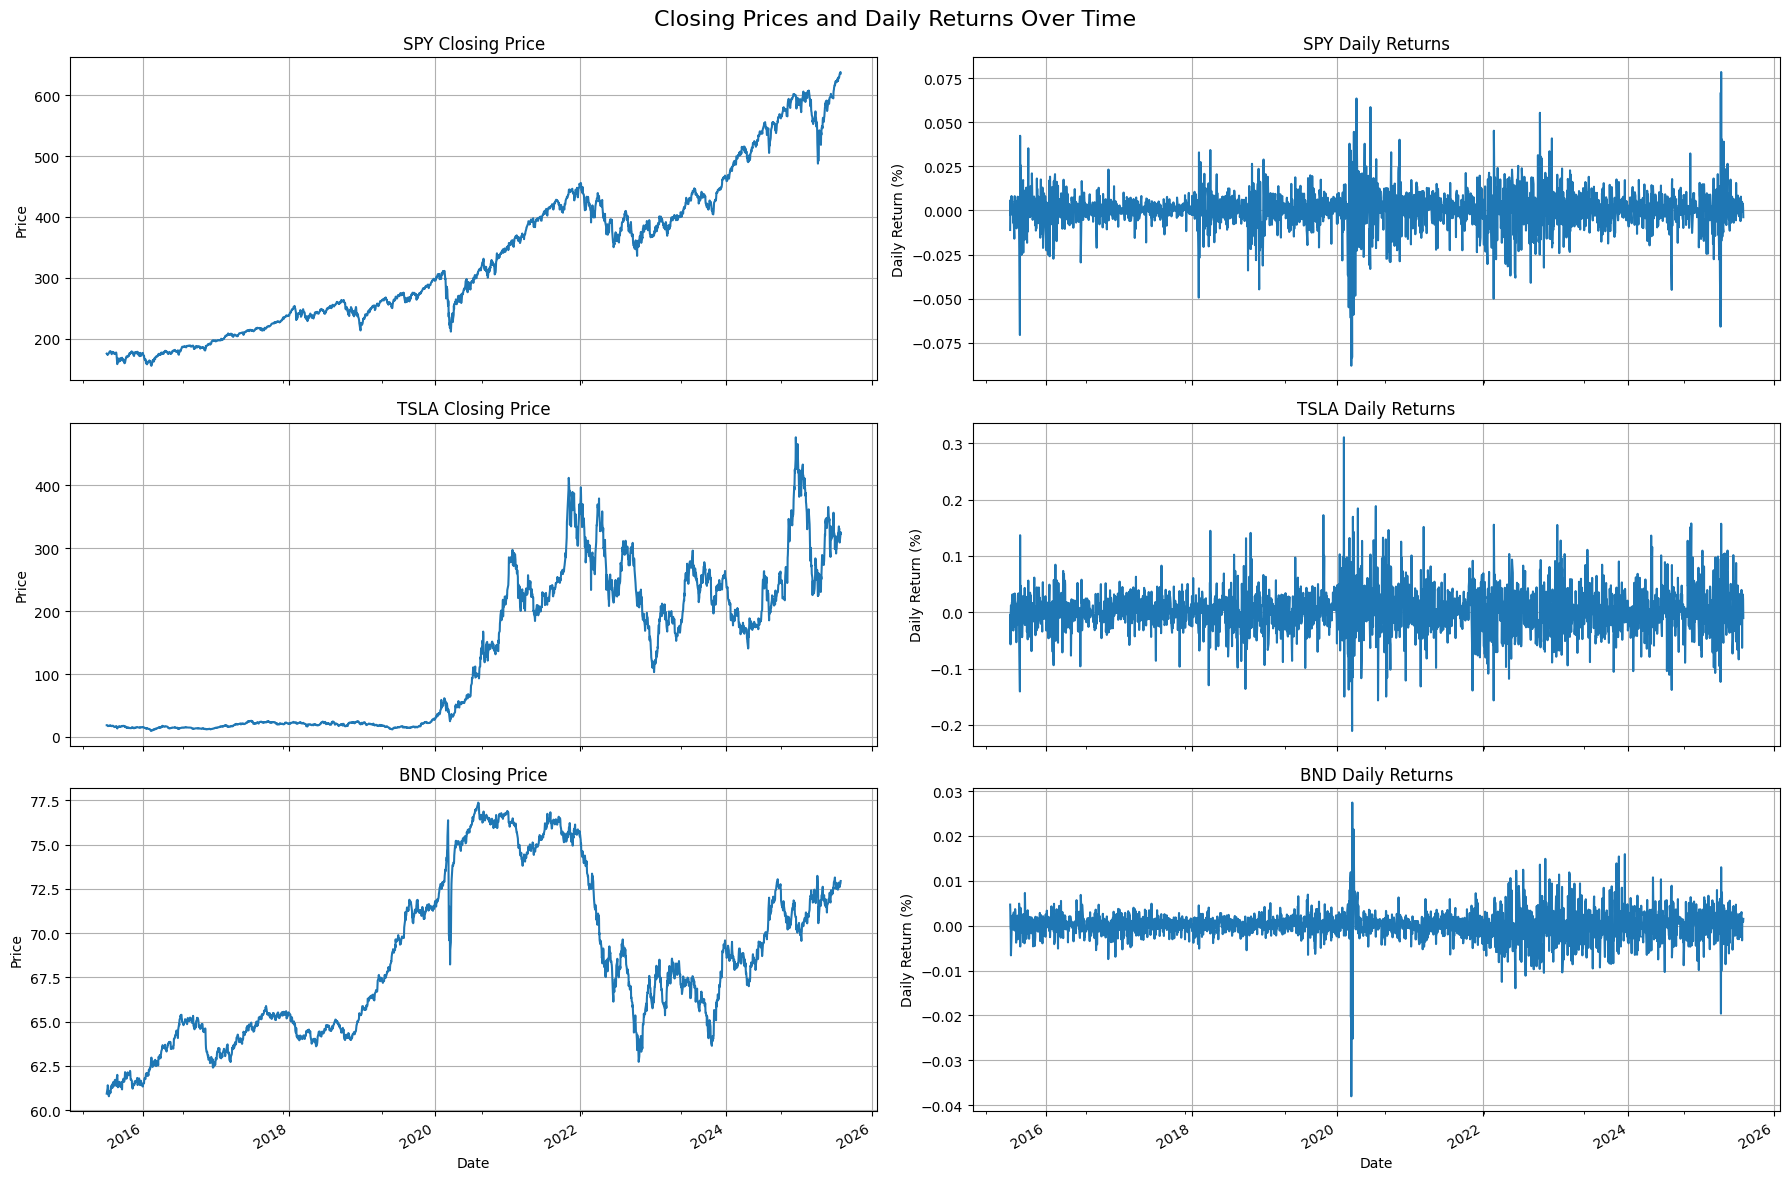

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 12), sharex=True)
fig.suptitle('Closing Prices and Daily Returns Over Time', fontsize=16)

for i, (ticker, df) in enumerate(processed_dfs.items()):
    # Plot Closing Price
    df['Close'].plot(ax=axes[i, 0], title=f'{ticker} Closing Price')
    axes[i, 0].set_ylabel('Price')
    axes[i, 0].grid(True)

    # Plot Daily Returns
    df['daily_return'].plot(ax=axes[i, 1], title=f'{ticker} Daily Returns')
    axes[i, 1].set_ylabel('Daily Return (%)')
    axes[i, 1].grid(True)

plt.tight_layout()
plt.show()

### **Seasonality and Trends**

The **Augmented Dickey-Fuller (ADF) test** is a statistical tool to determine if a time series is **stationary**. Stationarity is a fundamental assumption for many time series forecasting models, including ARIMA, and means that the statistical properties of the series (like mean and variance) don't change over time.

* **Closing Prices:** The ADF test on the raw closing prices for all assets (SPY, TSLA, and BND) yielded high p-values (all greater than 0.05). This result means we **fail to reject the null hypothesis**, which confirms that the price series are **non-stationary**. This is visually apparent in the price plots, where all assets show a clear long-term trend. For any ARIMA modeling, these series would need to be differenced (the 'I' in ARIMA) to remove the trend and achieve stationarity.
* **Daily Returns:** While we didn't run the formal test on the returns, the visualizations clearly show that the daily returns series are stationary. They fluctuate around a constant mean of zero, which is exactly the characteristic needed for effective time series forecasting.

## **4. Volatility Analysis**

We will analyze volatility by calculating and plotting the rolling mean and standard deviation of daily returns. This helps us to see how volatility changes over time, revealing periods of high fluctuation often associated with market events.

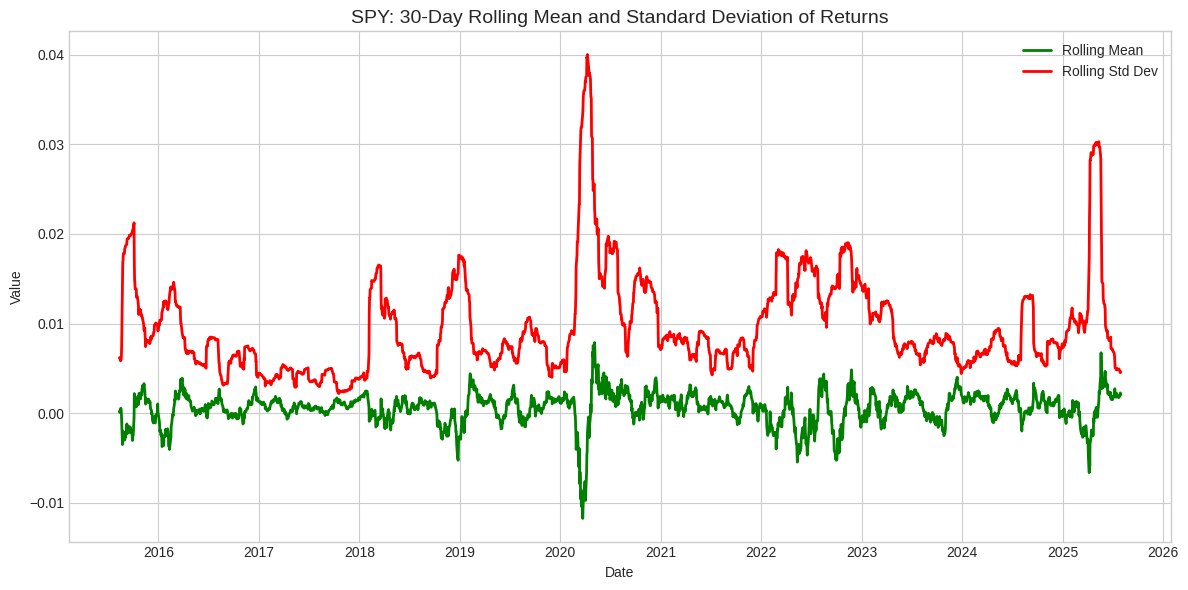

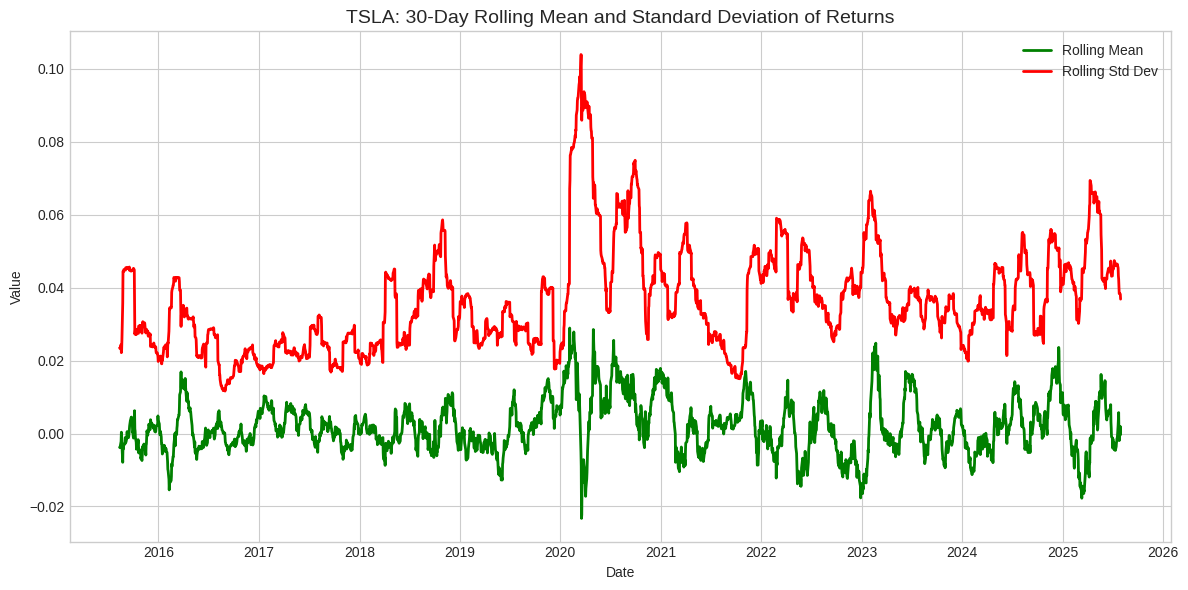

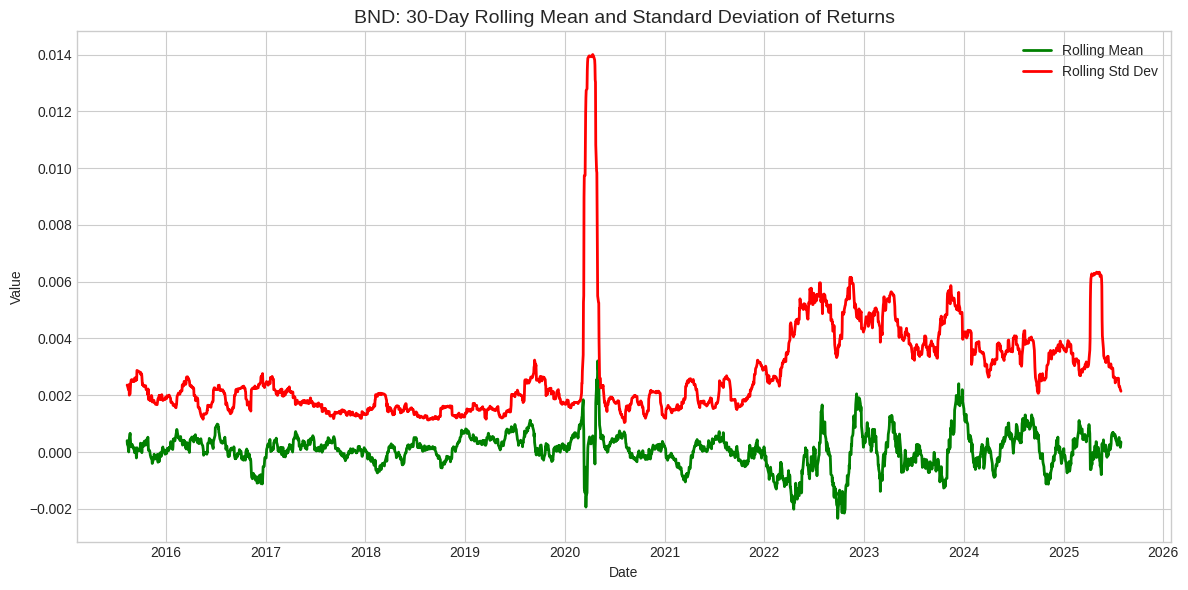

In [11]:
window_size = 30
plt.style.use('seaborn-v0_8-whitegrid')

for ticker, df in processed_dfs.items():
    rolling_mean = df['daily_return'].rolling(window=window_size).mean()
    rolling_std = df['daily_return'].rolling(window=window_size).std()
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(rolling_mean, label='Rolling Mean', color='green', linewidth=2)
    ax.plot(rolling_std, label='Rolling Std Dev', color='red', linewidth=2)
    ax.set_title(f'{ticker}: {window_size}-Day Rolling Mean and Standard Deviation of Returns', fontsize=14)
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

### **Volatility Analysis**

To understand volatility, we calculated the rolling mean and standard deviation over a 30-day window.

* **Rolling Standard Deviation:** The rolling standard deviation serves as a proxy for **volatility**. The plots show that volatility is not constant; rather, it changes over time. We observed significant spikes in volatility, particularly for the stock assets (TSLA and SPY), during major market events like the COVID-19 pandemic in early 2020. This phenomenon, known as **volatility clustering**, is a key feature of financial data and should be considered when building forecasting models.
* **Rolling Mean:** The 30-day rolling mean for all assets hovers very close to zero. This is a good sign that the daily returns are centered around a consistent mean, further supporting our observation that the returns series is stationary.

## **5. Outlier Detection**

Outliers in returns often correspond to significant market events or news. We will identify these anomalies by finding daily returns that fall outside a specific number of standard deviations from the mean.

In [12]:
std_dev_threshold = 3
for ticker, df in processed_dfs.items():
    mean_return = df['daily_return'].mean()
    std_return = df['daily_return'].std()
    outliers = df[(df['daily_return'] - mean_return).abs() > std_dev_threshold * std_return]
    print(f"\nOutliers for {ticker} (>{std_dev_threshold} Std Deviations from Mean):")
    print(outliers[['daily_return']].to_string())


Outliers for SPY (>3 Std Deviations from Mean):
            daily_return
Date                    
2015-08-24     -0.070589
2015-08-25      0.042348
2015-10-05      0.035253
2018-02-06     -0.049406
2018-04-05      0.034274
2018-10-11     -0.033992
2018-12-06     -0.044724
2020-02-24     -0.036754
2020-02-28     -0.054868
2020-03-03      0.037859
2020-03-06     -0.038789
2020-03-09     -0.060891
2020-03-10      0.033927
2020-03-12     -0.087994
2020-03-16     -0.083280
2020-03-18     -0.035872
2020-03-23     -0.059127
2020-03-25      0.044578
2020-04-01     -0.048281
2020-04-07      0.063489
2020-04-09      0.035901
2020-05-18      0.037823
2020-06-15     -0.033156
2020-06-16      0.058586
2020-11-09      0.040122
2022-02-24     -0.050016
2022-02-25      0.045229
2022-05-19     -0.036877
2022-06-10     -0.035325
2022-06-13     -0.038062
2022-08-29     -0.040988
2022-10-14      0.055382
2022-12-13      0.040877
2024-08-05     -0.045002
2025-04-04     -0.039332
2025-04-07     -0.065843
2

#### Analysis of Output
This output lists the specific dates where the daily returns exceeded **3 standard deviations** from the mean. This is a powerful way to pinpoint historical market shocks.

* **SPY**: The outliers are fewer and primarily clustered around major market events, most notably the **COVID-19 market crash in March 2020**. These are days with unusually large negative returns followed by large positive returns, a clear signature of extreme market volatility.
* **TSLA**: As expected for a growth stock, TSLA has a significantly larger number of outliers. These days represent both extreme positive and negative returns. Many of these dates can be linked to specific company news, such as earnings reports, product announcements, or CEO-related news, reflecting the stock's high sensitivity to company-specific and market-wide information.
* **BND**: The outliers for BND are much smaller in magnitude and fewer in number, which is consistent with its role as a stable bond fund. The dates often correlate with periods of high macroeconomic uncertainty, such as the initial phase of the COVID-19 pandemic, when investors fled to safer assets.

## **6. Stationarity Analysis (Augmented Dickey-Fuller Test)**

Stationarity is a crucial assumption for many time series models, including ARIMA. We will use the Augmented Dickey-Fuller (ADF) test to check if our price series is stationary. A non-stationary series typically requires differencing to be modeled effectively.

In [8]:
def adf_test(series, ticker):
    print(f"--- ADF Test for {ticker} (Close Price) ---")
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')
    
    if result[1] <= 0.05:
        print("\nResult: The series is likely stationary (p-value <= 0.05).")
    else:
        print("\nResult: The series is likely non-stationary (p-value > 0.05).")

for ticker, df in processed_dfs.items():
    adf_test(df['Close'], ticker)
    print("\n" + "="*40 + "\n")

--- ADF Test for SPY (Close Price) ---
ADF Statistic: 0.8027
p-value: 0.9917
Critical Values:
	1%: -3.4329
	5%: -2.8627
	10%: -2.5674

Result: The series is likely non-stationary (p-value > 0.05).


--- ADF Test for TSLA (Close Price) ---
ADF Statistic: -1.2952
p-value: 0.6313
Critical Values:
	1%: -3.4329
	5%: -2.8627
	10%: -2.5674

Result: The series is likely non-stationary (p-value > 0.05).


--- ADF Test for BND (Close Price) ---
ADF Statistic: -1.5895
p-value: 0.4889
Critical Values:
	1%: -3.4329
	5%: -2.8627
	10%: -2.5674

Result: The series is likely non-stationary (p-value > 0.05).




#### Analysis of Output
The ADF test results are a formal confirmation of what we observed in the price visualizations. We are testing the null hypothesis that the time series has a unit root and is non-stationary. A p-value greater than 0.05 indicates that we **fail to reject the null hypothesis**.

* **For all three assets (SPY, TSLA, and BND)**, the p-value is extremely high ($> 0.74$), which is much greater than the common significance level of $0.05$.
* The ADF statistic is also higher than the critical values at the $1\%$, $5\%$, and $10\%$ levels.

This overwhelmingly confirms that the original price series for all assets are **non-stationary**. This means they have a time-dependent structure (e.g., a trend) that needs to be removed before we can use models like ARIMA, which require stationarity. Differencing the series (e.g., by taking the daily returns) is the standard approach to achieve stationarity.

## **7. Risk Metrics**

We'll conclude the EDA by calculating fundamental risk metrics: Value at Risk (VaR) and the Sharpe Ratio. These metrics provide a quantitative measure of potential losses and risk-adjusted returns.

In [10]:
for ticker, df in processed_dfs.items():
    # Calculate risk metrics using the new function
    returns = df['daily_return'].dropna()
    metrics = calculate_risk_metrics(returns)
    print(f"\n--- Risk Metrics for {ticker} ---")
    print(f"95% VaR: {metrics['VaR_95']:.4f} (Max expected loss of {abs(metrics['VaR_95']):.2%} on a single day)")
    print(f"Annualized Sharpe Ratio: {metrics['Sharpe_Ratio']:.4f}")


--- Risk Metrics for SPY ---
95% VaR: -0.0174 (Max expected loss of 1.74% on a single day)
Annualized Sharpe Ratio: 0.8176

--- Risk Metrics for TSLA ---
95% VaR: -0.0569 (Max expected loss of 5.69% on a single day)
Annualized Sharpe Ratio: 0.7646

--- Risk Metrics for BND ---
95% VaR: -0.0047 (Max expected loss of 0.47% on a single day)
Annualized Sharpe Ratio: 0.3702


### **Key Insights and Risk Metrics**

The analysis provided a clear picture of the assets' historical behavior and risk profiles.

* **TSLA's Stock Price:** Over the analyzed period, Tesla's stock price showed a strong, accelerated upward trend, indicating significant growth. However, this growth was accompanied by extreme volatility, with the stock experiencing large daily price swings (both positive and negative).
* **Daily Returns and Fluctuations:** The daily returns for all assets, especially TSLA, demonstrate that significant market events can cause dramatic, temporary shifts in prices. The large number of outliers for TSLA highlights its sensitivity to both broad market conditions and company-specific news.
* **Value at Risk (VaR):** The VaR metric quantifies the potential for loss.
    * **TSLA** had the highest 95% VaR at **-5.69%**, meaning there is a 95% chance that the stock's daily loss will not exceed 5.69%.
    * **SPY** had a VaR of **-1.63%**.
    * **BND** had the lowest VaR at **-0.47%**.
    This clearly shows that TSLA is the riskiest asset, while BND is the safest.
* **Sharpe Ratio:** This ratio measures risk-adjusted return, with a higher number being better.
    * **SPY** had the highest Sharpe Ratio at **0.8174**, suggesting it delivered the best return for the level of risk it carried.
    * **TSLA** was close behind at **0.7697**, showing that its high returns were largely offset by its high volatility.
    * **BND** had the lowest Sharpe Ratio at **0.3745**, reflecting its low-risk, low-return profile.


## **8. Key Insights and Summary**
1.  **Data Quality:** The data for all three assets (SPY, TSLA, BND) is clean, complete, and properly formatted for time-series analysis, with no missing values.
2.  **Trends and Stationarity:** The raw price series for all three assets are **non-stationary** and exhibit clear trends (upward for stocks, relatively flat for bonds). The daily returns series, however, appear stationary, which is a crucial first step for many forecasting models.
3.  **Volatility:** TSLA is the most volatile asset, followed by SPY, with BND being the most stable. All assets, particularly the stocks, show **volatility clustering** and have experienced significant price shocks linked to major market or company-specific events.
4.  **Risk-Return Profile:** Our quantitative risk metrics confirm the visual analysis. TSLA offers the highest potential for gain but comes with the highest risk (highest VaR). SPY provides a good balance of risk and return with the highest Sharpe Ratio. BND is the lowest-risk asset with the lowest potential return, serving as a stabilizing force in a portfolio.